In [124]:
import numpy as np
import pylab as pl
import matplotlib.gridspec as gridspec
from glob import glob
import tensorflow as tf
%matplotlib inline

#train1 = glob('data/Tc/01/??/Tc.016???.npy')
#train2 = glob('data/Tc2/01/??/TcS2.1.016???.npy')
#train3 = glob('data/surface/01/??/surfaceTypeIndex.016???.npy')
#label2 = glob('data/heightstorm/01/??/heightStormTop.1.016???.npy') 

baseDir= '/mnt/j/PMM/MATCH.GMI.V05A'
train1 = glob(baseDir + '/S1.ABp103-117.GMI.Tc/2017/01/??/Tc.016???.npy')
train2 = glob(baseDir + '/S1.ABp103-117.GMI.TcS2/2017/01/??/TcS2.1.016???.npy')
train3 = glob(baseDir + '/S1.ABp103-117.GMI.surfaceTypeIndex/2017/01/??/surfaceTypeIndex.016???.npy')
label2 = glob(baseDir + '/S1.ABp103-117.Ku.V06A.heightStormTop/2017/01/??/heightStormTop.1.016???.npy') 

#train1   = np.concatenate([np.load(i) for i in train1])
#train2   = np.concatenate([np.load(i) for i in train2])
#train3   = np.concatenate([np.load(i) for i in train3]) # set = {1,2,3,4,5, ... , 14}
#label2   = np.concatenate([np.load(i) for i in label2]) 
print 'num-files=',len(train1)
print train1[0]
print train1[-1]
train1.sort()
train2.sort()
train3.sort()
label2.sort()
train1   = np.concatenate([np.load(i) for i in train1[:]])
train2   = np.concatenate([np.load(i) for i in train2[:]])
train3   = np.concatenate([np.load(i) for i in train3[:]]) # set = {1,2,3,4,5, ... , 14}
label2   = np.concatenate([np.load(i) for i in label2[:]]) 

N = len(train1)

print(train1.shape, train2.shape, train3.shape, label2.shape)

num-files= 482
/mnt/j/PMM/MATCH.GMI.V05A/S1.ABp103-117.GMI.Tc/2017/01/01/Tc.016155.npy
/mnt/j/PMM/MATCH.GMI.V05A/S1.ABp103-117.GMI.Tc/2017/01/31/Tc.016636.npy
((1427693, 15, 9), (1427693, 15, 4), (1427693, 15), (1427693, 15))


In [197]:
train3 = train3.reshape(N,15,1)  
train_total = np.concatenate([train1,train2,train3],axis=2)
label = label2
print(train_total.shape, label.shape)

((1427693, 15, 14), (1427693, 15))


In [198]:
Shape    = [3, 7]
trainbox = []
surface  = []
labelbox = []
row_mid  = int((Shape[0]-1)/2)
col_mid  = int((Shape[1]-1)/2)
k0 = 0  # test
k1 = 0  # test
for i in range(N-Shape[0]+1): 
    for j in range(15-Shape[1]+1):   # range(9)
        k0 = k0+15555
        if (label[i+row_mid, j+col_mid] < 0):continue     # includes storm top==0.
        #if (label[i:i+Shape[0], j:j+Shape[1]].flatten() < 0).sum() == 0:     # includes storm top==0.
        #if (label[i:i+Shape[0], j:j+Shape[1]].flatten() < 0).sum() <=15:     # includes storm top==0.
        #if (label[i:i+Shape[0], j:j+Shape[1]].flatten() < 0).sum() <=20:     # includes storm top==0.
        if (label[i:i+Shape[0], j:j+Shape[1]].flatten() < 0).sum() <=7:     # includes storm top==0.
            k1=k1+1 
            trainbox.append(train_total[i:i+Shape[0], j:j+Shape[1], :-1])
            surface.append( train_total[i+row_mid   , j+col_mid   ,  -1])
            labelbox.append(label[i+row_mid, j+col_mid])
print(len(trainbox), len(labelbox), len(surface), trainbox[0].shape, surface[0], labelbox[0])
print k0,k1, (N-Shape[0]+1)*(15-Shape[1]+1)

(367362, 367362, 367362, (3, 7, 13), 1.0, 3733.6528)
199869601545 367362 12849219


In [199]:
train_tem1 = np.array([trainbox[i].flatten() for i in range(len(trainbox))])
train_tem2 = np.array(surface).reshape(-1,1)
train      = np.concatenate([train_tem1, train_tem2], axis=1)
label      = np.array(labelbox).reshape(-1,1)
print(train.shape, label.shape)

((367362, 274), (367362, 1))


In [200]:
index_remove = []
for i in range(len(train)):
    if (train[i] < 0).sum() > 0:
        index_remove.append(i)
print(len(index_remove) )

95


In [201]:
index = np.delete(np.arange(len(train)), index_remove)
print(len(index))

367267


In [202]:
t = np.array([train[i] for i in index])
l = np.array([label[i] for i in index])
print(t.shape, l.shape)

((367267, 274), (367267, 1))


In [203]:
mat = t[:,:-1]
cov = float(1)/mat.shape[1]*np.dot(mat.T, mat)
u,s,v = np.linalg.svd(cov)

In [204]:
factor = 10
print(s[:factor].sum()/s.sum()),s.sum()
#print np.dot(mat.T, mat)

0.9991075 18985282000.0


In [205]:
reduction = np.dot(mat, u[:,:factor])
U = u[:,:factor]
print(reduction.shape, U.shape)

((367267, 10), (273, 10))


In [206]:
t = np.concatenate([reduction, t[:,-1].reshape(-1,1)], axis=1)
print(t.shape)

(367267, 11)


In [207]:
grouping_train = [[] for i in range(14)]
grouping_label = [[] for i in range(14)]
for i in range(len(t)):
    for j in range(14):
        if t[i,-1] == j+1:
            grouping_train[j].append(t[i])
            grouping_label[j].append(l[i])
Gtrain = [ np.array(grouping_train[i]) for i in range(14) ]
Glabel = [ np.array(grouping_label[i]) for i in range(14) ]
for i in range(14):
    print(Gtrain[i].shape, Glabel[i].shape, set(Gtrain[i][:,-1]))

((287040, 11), (287040, 1), set([1.0]))
((2033, 11), (2033, 1), set([2.0]))
((22887, 11), (22887, 1), set([3.0]))
((7390, 11), (7390, 1), set([4.0]))
((5314, 11), (5314, 1), set([5.0]))
((2482, 11), (2482, 1), set([6.0]))
((714, 11), (714, 1), set([7.0]))
((1344, 11), (1344, 1), set([8.0]))
((5610, 11), (5610, 1), set([9.0]))
((3090, 11), (3090, 1), set([10.0]))
((5704, 11), (5704, 1), set([11.0]))
((5242, 11), (5242, 1), set([12.0]))
((17485, 11), (17485, 1), set([13.0]))
((932, 11), (932, 1), set([14.0]))


In [208]:
Max = [ np.max(Glabel[i]) for i in range(14) ]
Min = [ np.min(Glabel[i]) for i in range(14) ]
def unit(x):
    return ( x - np.min(x,0) )/( np.max(x,0) - np.min(x,0) )

In [209]:
Train  = [ unit(Gtrain[i][:,:-1]) for i in range(14) ]
Label  = [ unit(Glabel[i])        for i in range(14) ]
ntrain = [ int(0.7*len(Train[i])) for i in range(14) ]
trainX = [ Train[i][:ntrain[i]]   for i in range(14) ]
trainY = [ Label[i][:ntrain[i]]   for i in range(14) ]
testX  = [ Train[i][ntrain[i]:]   for i in range(14) ]
testY  = [ Label[i][ntrain[i]:]   for i in range(14) ]
for i in range(14):
    print(trainX[i].shape, trainY[i].shape, testX[i].shape, testY[i].shape)

((200928, 10), (200928, 1), (86112, 10), (86112, 1))
((1423, 10), (1423, 1), (610, 10), (610, 1))
((16020, 10), (16020, 1), (6867, 10), (6867, 1))
((5173, 10), (5173, 1), (2217, 10), (2217, 1))
((3719, 10), (3719, 1), (1595, 10), (1595, 1))
((1737, 10), (1737, 1), (745, 10), (745, 1))
((499, 10), (499, 1), (215, 10), (215, 1))
((940, 10), (940, 1), (404, 10), (404, 1))
((3926, 10), (3926, 1), (1684, 10), (1684, 1))
((2163, 10), (2163, 1), (927, 10), (927, 1))
((3992, 10), (3992, 1), (1712, 10), (1712, 1))
((3669, 10), (3669, 1), (1573, 10), (1573, 1))
((12239, 10), (12239, 1), (5246, 10), (5246, 1))
((652, 10), (652, 1), (280, 10), (280, 1))


In [210]:
def app(x,x_val,y_val,degree):
    mat  = np.concatenate([(x_val**i).reshape(-1,1) for i in range(degree)], axis=1)
    coef = np.dot(np.linalg.inv(np.dot(mat.T, mat)), np.dot(mat.T, y_val))
    return sum([coef[i]*(x**i) for i in range(degree)]),coef
def coefficient(x,K,degree,divide_factor,trans_up): # K:number of interval, trans_up: transition in y axis
    unit_interval = np.arange(K+1)/float(K)
    revised_unit_interval = unit_interval[:-1] + 1/float(2*K)
    vec = x.flatten()
    number_unit   = []
    for i in range(K):
        number_unit.append( (vec < unit_interval[i+1] ).sum() - (vec < unit_interval[i] ).sum() )
    num = np.array(number_unit) 
    LM = np.max(num)
    reflect = (- num + LM)/float(divide_factor) + trans_up
    xx = np.arange(1001)/1000. + 1/2000.
    return app(xx,revised_unit_interval, reflect,degree)[1]

In [211]:
def stochastic(TraX, TraY, TesX, TesY, learning_rate, epochs, batch_size, dim): 
    total_batch = int(len(TraX) / batch_size) + 1
    Xdata = [ TraX[i*batch_size:(i+1)*batch_size] for i in range(total_batch) ]
    Ydata = [ TraY[i*batch_size:(i+1)*batch_size] for i in range(total_batch) ]

    fn1 = tf.nn.sigmoid
    fn2 = tf.nn.relu
    ac = [fn1, fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1] # number of entry = len(dim) - 2

    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, TraX.shape[1]])
    Y = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    Z = sum([ coefficient(TesY,20,7,300,0.1)[i]*(Y**i) for i in range(7) ])

    W = [ tf.Variable(tf.random_normal([dim[i], dim[i+1]])) for i in range(len(dim) - 1) ]
    b = [ tf.Variable(tf.random_normal([dim[i+1]]))         for i in range(len(dim) - 1) ]
    A = [X]
    for i in range(len(dim) - 2):
        A.append(ac[i](tf.matmul(A[-1],W[i]) + b[i]))               
    A.append(tf.matmul(A[-1], W[-1]) + b[-1])  
    cost = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(Y - A[-1])*Z  ))) 
    gogo = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    real = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    pred = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    rmse = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(real - pred))))
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):    
        for i in range(total_batch):
            feed1 = {X:Xdata[i], Y:Ydata[i]}
            sess.run(gogo, feed_dict = feed1)
            training_error = sess.run(cost, feed_dict = feed1)
            prediction     = sess.run(A[-1], feed_dict = {X:TesX})
            test_error     = sess.run(rmse, feed_dict = {real:TesY, pred:prediction})
        if epoch % int(epochs/5) == 0:    
            print('Training Error:',training_error,'and','Testing Error:', test_error)
    return prediction, sess.run(W[0])

def FFN(TraX, TraY, TesX, TesY, learning_rate, iterations, dim): 
    fn1 = tf.nn.sigmoid
    fn2 = tf.nn.relu
    ac = [fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1] # number of entry = len(dim) - 2

    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, TraX.shape[1]])
    Y = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    Y = tf.add(Y,0.001)
    Z = sum([ coefficient(TesY,20,7,300,0.1)[i]*(Y**i) for i in range(7) ])  # test
    
    W = [ tf.Variable(tf.random_normal([dim[i], dim[i+1]])) for i in range(len(dim) - 1) ]
    b = [ tf.Variable(tf.random_normal([dim[i+1]]))         for i in range(len(dim) - 1) ]
    A = [X]
    for i in range(len(dim) - 2):
        A.append(ac[i](tf.matmul(A[-1],W[i]) + b[i]))
    A.append(tf.matmul(A[-1], W[-1]) + b[-1])  
    cost = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(Y - A[-1])*Z   ))) 
    #cost = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(Y - A[-1])  )))   # test
    gogo = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    real = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    pred = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    rmse = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(real - pred))))
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for iteration in range(iterations):
        feed1 = {X:TraX, Y:TraY}
        sess.run(gogo, feed_dict = feed1)
        training_error = sess.run(cost, feed_dict = feed1)
        prediction     = sess.run(A[-1], feed_dict = {X:TesX})
        test_error     = sess.run(rmse, feed_dict = {real:TesY, pred:prediction})
        if iteration % int(iterations/5) == 0:    
            print('Training Error:',training_error,'and','Testing Error:', test_error) 
    return prediction, sess.run(W[0])

def Figure(Label, Prediction, bins, Type):
    def rmse(x,y):
        return np.sqrt(((x.flatten()-y.flatten())**2).mean())
    def Rmse(x,y):
        return np.sqrt(((((Max[Type]-Min[Type])*x+Min[Type]).flatten()-
                         ((Max[Type]-Min[Type])*y+Min[Type]).flatten())**2).mean())
    def cc(x,y):
        return np.corrcoef(x.flatten(),y.flatten())[0,1]
    recover_testY = (Max[Type]-Min[Type])*Label.flatten()      + Min[Type]
    recover_pred  = (Max[Type]-Min[Type])*Prediction.flatten() + Min[Type]
    pl.figure(figsize=(15,7))
    gs = gridspec.GridSpec(2,3, width_ratios=[1,1,1], height_ratios=[1,2])
    
    pl.subplot(gs[0,:])
    pl.plot((recover_testY)/1000., c='r', label ='Observation')
    pl.plot((recover_pred) /1000., c='b', label ='Prediction')
    pl.ylabel('height(km)')
    pl.legend()
    print('RMSE:'     , np.round(rmse(Label, Prediction) , 4))
    print('real RMSE:', np.round(Rmse(Label, Prediction) , 4))
    print('CC:'       , np.round(  cc(Label, Prediction) , 4))
    
    pl.subplot(gs[3]) # values prediction and testY are between -4 and 4
    aa = recover_pred
    bb = recover_testY
    interval           = np.array([ Min[Type] + (Max[Type] - Min[Type])/bins*i for i in range(bins+1) ])
    interval1          = np.array([ Min[Type] + (Max[Type] - Min[Type])/bins*i for i in range(bins+1) ])
    revised_interval   = interval[:-1]  + (Max[Type] - Min[Type])/(2*bins)
    revised_interval1  = interval1[:-1] + (Max[Type] - Min[Type])/(2*bins)
    cumulative_number  = []
    cumulative_number1 = []
    for i in range(bins):
        cumulative_number.append(  (aa < interval[i+1] ).sum() - (aa < interval[i] ).sum() )
        cumulative_number1.append( (bb < interval1[i+1]).sum() - (bb < interval1[i]).sum() )
    pl.plot(revised_interval/1000.          , cumulative_number   , color='green', alpha=0.5, label='Prediction')    
    pl.fill_between(revised_interval/1000.  , cumulative_number, 0, color='green', alpha=0.5)
    pl.plot(revised_interval1/1000.         , cumulative_number1  , color='red'  , alpha=0.5 ,label='Observation')    
    pl.fill_between(revised_interval1/1000. ,cumulative_number1, 0, color='red'  , alpha=0.5)
    pl.ylabel('number of sample')
    pl.xlabel('height(km)')
    pl.legend() 
    pl.title('Distribution')
    pl.legend()
    
    pl.subplot(gs[4])
    pl.scatter(recover_testY/1000., recover_pred/1000.,s=1)
    pl.plot(np.arange(18000)/1000.,np.arange(18000)/1000.,c='black',linestyle = ':')
    pl.axis([0,18,0,18])
    pl.xticks([0,5,10,15])
    pl.yticks([0,5,10,15])
    pl.xlabel('Observation(km)')
    pl.ylabel('Prediction(km)')
    pl.title('Correlation')
    pl.grid()
def rmse(x,y):
    return np.sqrt(((x.flatten()-y.flatten())**2).mean())

In [212]:
# Surface index 1
Type = 1 - 1
print(trainX[Type].shape)

(200928, 10)


('Training Error:', 0.81157357, 'and', 'Testing Error:', 0.19435272)
('Training Error:', 0.26403585, 'and', 'Testing Error:', 0.07955884)
('Training Error:', 0.24647655, 'and', 'Testing Error:', 0.07767921)
('Training Error:', 0.23912622, 'and', 'Testing Error:', 0.077284746)
('Training Error:', 0.23396342, 'and', 'Testing Error:', 0.07577731)
('RMSE:', 0.0751)
('real RMSE:', 1548.4009)
('CC:', 0.8415)


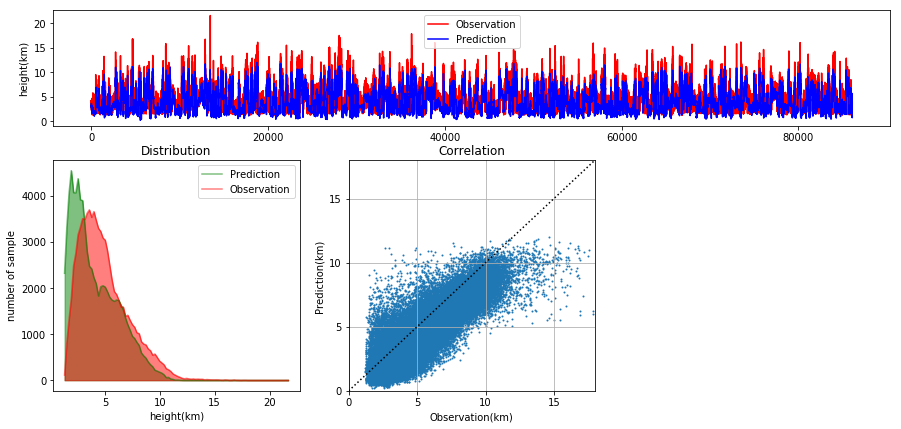

In [213]:
dim = [trainX[Type].shape[1], 30,30,30, trainY[Type].shape[1]]
prediction, W = stochastic(trainX[Type], trainY[Type], testX[Type], testY[Type], 0.005, 20, 4096, dim)
#prediction, W = FFN(trainX[Type], trainY[Type], testX[Type], testY[Type], 0.005, 20, dim)
#prediction, W = FFN(TraX, TraY, TesX, TesY, learning_rate, iterations, dim)
Figure(testY[Type], prediction, 100, Type)